# Custom Sleep Analysis
## Interactive analysis of your sleep patterns and statistics


In [1]:
import warnings
warnings.filterwarnings('ignore', message='Glyph.*missing from font')
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

# Connect to database
db_path = os.path.expanduser('~/HealthData/DBs/garmin.db')
conn = sqlite3.connect(db_path)

print('✅ Connected to GarminDB')


✅ Connected to GarminDB


In [2]:
# Load and analyze your sleep data
query = """
SELECT 
    day,
    total_sleep,
    deep_sleep,
    light_sleep,
    rem_sleep,
    awake,
    score,
    avg_spo2,
    avg_stress
FROM sleep 
WHERE day >= date('now', '-365 days')
  AND total_sleep IS NOT NULL 
ORDER BY day DESC;
"""

df = pd.read_sql_query(query, conn)
df['day'] = pd.to_datetime(df['day'])

# Convert time strings to hours
def time_to_hours(time_str):
    if pd.isna(time_str) or time_str == '00:00:00':
        return np.nan
    try:
        hours = int(time_str[:2])
        minutes = int(time_str[3:5])
        return hours + minutes/60.0
    except:
        return np.nan

# Convert sleep durations to hours
sleep_cols = ['total_sleep', 'deep_sleep', 'light_sleep', 'rem_sleep', 'awake']
for col in sleep_cols:
    df[f'{col}_hours'] = df[col].apply(time_to_hours)

# Calculate comprehensive statistics
valid_sleep = df[df['total_sleep_hours'] > 0]['total_sleep_hours']

print("🌙 YOUR SLEEP STATISTICS (Last Year)")
print("=" * 40)
print(f"📊 Nights recorded: {len(valid_sleep)}")
print(f"📊 Average: {valid_sleep.mean():.1f} hours")
print(f"📊 Median: {valid_sleep.median():.1f} hours") 
print(f"📊 Std Deviation: {valid_sleep.std():.1f} hours")
print(f"📊 Range: {valid_sleep.min():.1f} - {valid_sleep.max():.1f} hours")
print(f"📊 75th Percentile: {valid_sleep.quantile(0.75):.1f} hours")
print(f"📊 25th Percentile: {valid_sleep.quantile(0.25):.1f} hours")

# Sleep quality
scores = df['score'].dropna()
print(f"\n💯 Sleep Score: {scores.mean():.0f} avg (±{scores.std():.1f})")
print(f"💯 Best Score: {scores.max():.0f}")
print(f"💯 SpO2: {df['avg_spo2'].mean():.1f}% avg")

print("\n📈 Ready for visualizations! Run the next cells...")


🌙 YOUR SLEEP STATISTICS (Last Year)
📊 Nights recorded: 358
📊 Average: 7.6 hours
📊 Median: 7.6 hours
📊 Std Deviation: 1.2 hours
📊 Range: 1.6 - 11.0 hours
📊 75th Percentile: 8.4 hours
📊 25th Percentile: 7.0 hours

💯 Sleep Score: 80 avg (±11.1)
💯 Best Score: 97
💯 SpO2: 95.4% avg

📈 Ready for visualizations! Run the next cells...


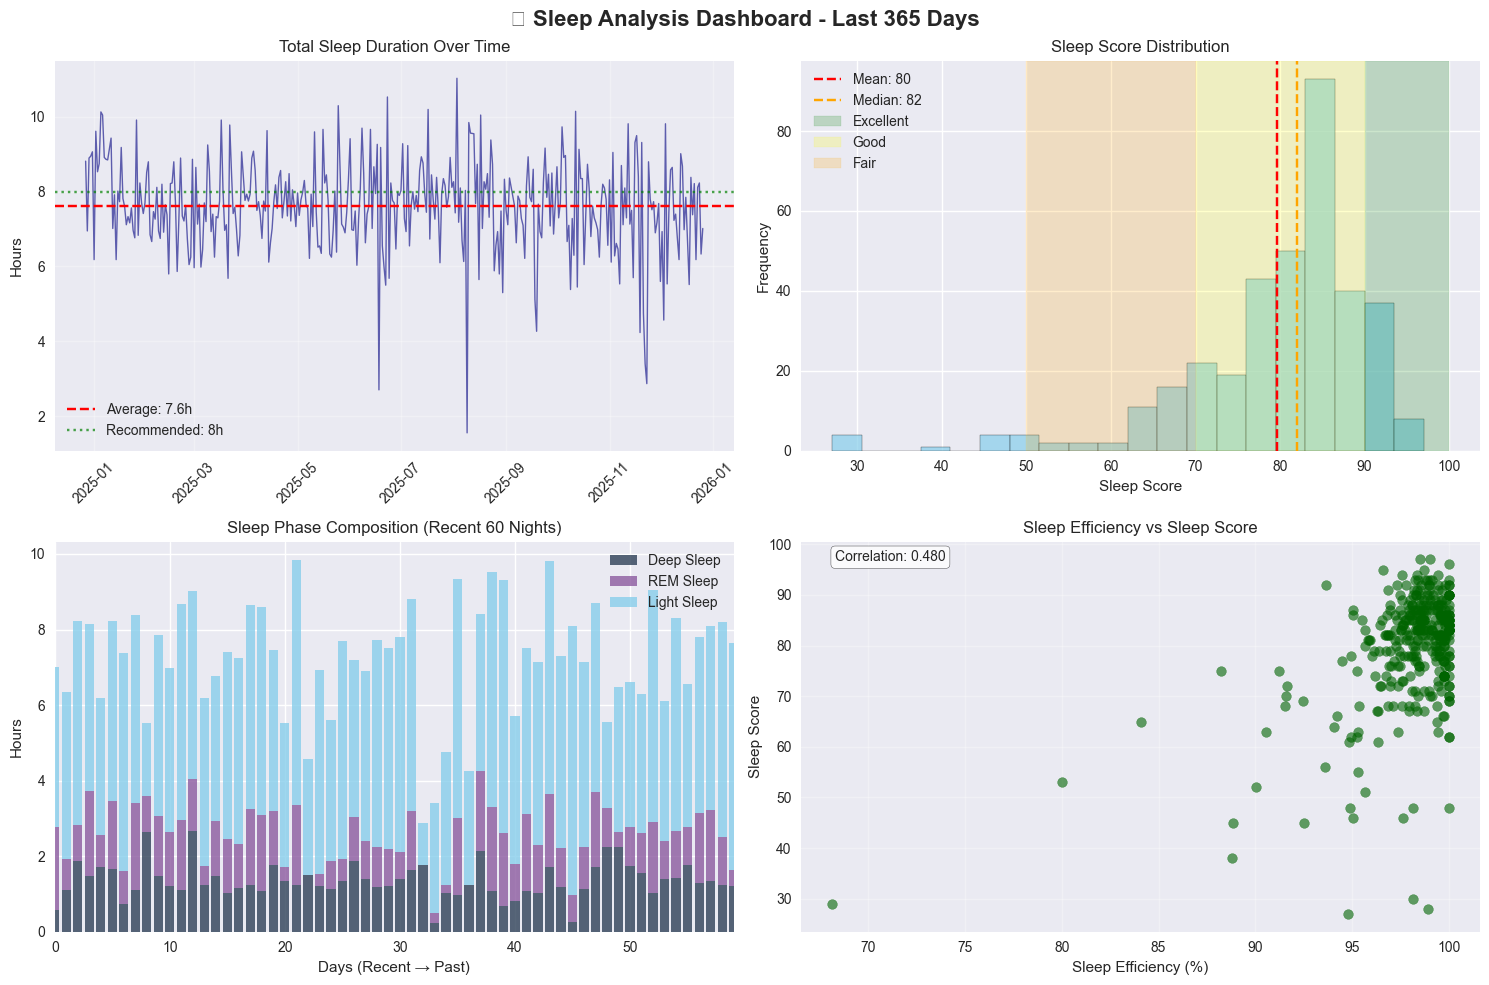

✨ Visualizations complete!


In [3]:
# Create comprehensive sleep visualizations
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('🌙 Sleep Analysis Dashboard - Last 365 Days', fontsize=16, fontweight='bold')

# 1. Sleep duration over time with trend
valid_data = df[df['total_sleep_hours'] > 0].copy()
axes[0,0].plot(valid_data['day'], valid_data['total_sleep_hours'], alpha=0.6, linewidth=1, color='navy')
axes[0,0].axhline(y=valid_data['total_sleep_hours'].mean(), color='red', linestyle='--', 
                  label=f'Average: {valid_data["total_sleep_hours"].mean():.1f}h')
axes[0,0].axhline(y=8, color='green', linestyle=':', alpha=0.7, label='Recommended: 8h')
axes[0,0].set_title('Total Sleep Duration Over Time')
axes[0,0].set_ylabel('Hours')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Sleep score distribution with quality zones
score_clean = df['score'].dropna()
axes[0,1].hist(score_clean, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].axvline(score_clean.mean(), color='red', linestyle='--', label=f'Mean: {score_clean.mean():.0f}')
axes[0,1].axvline(score_clean.median(), color='orange', linestyle='--', label=f'Median: {score_clean.median():.0f}')
# Add quality zones
axes[0,1].axvspan(90, 100, alpha=0.2, color='green', label='Excellent')
axes[0,1].axvspan(70, 90, alpha=0.2, color='yellow', label='Good') 
axes[0,1].axvspan(50, 70, alpha=0.2, color='orange', label='Fair')
axes[0,1].set_title('Sleep Score Distribution')
axes[0,1].set_xlabel('Sleep Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# 3. Sleep phases stacked chart (recent 60 nights)
recent_data = valid_data.head(60).copy()
phases = ['deep_sleep_hours', 'rem_sleep_hours', 'light_sleep_hours']
phase_labels = ['Deep Sleep', 'REM Sleep', 'Light Sleep']
colors = ['#2E4057', '#8B5A9F', '#87CEEB']

bottom = np.zeros(len(recent_data))
x_pos = range(len(recent_data))

for phase, label, color in zip(phases, phase_labels, colors):
    values = recent_data[phase].fillna(0)
    axes[1,0].bar(x_pos, values, bottom=bottom, label=label, color=color, alpha=0.8)
    bottom += values

axes[1,0].set_title('Sleep Phase Composition (Recent 60 Nights)')
axes[1,0].set_xlabel('Days (Recent → Past)')
axes[1,0].set_ylabel('Hours')
axes[1,0].legend()
axes[1,0].set_xlim(0, 59)

# 4. Sleep efficiency vs score correlation
df['sleep_efficiency'] = ((df['total_sleep_hours'] - df['awake_hours']) / df['total_sleep_hours'] * 100).clip(0, 100)
correlation_data = df[['sleep_efficiency', 'score']].dropna()

axes[1,1].scatter(correlation_data['sleep_efficiency'], correlation_data['score'], 
                  alpha=0.6, color='darkgreen')
axes[1,1].set_title('Sleep Efficiency vs Sleep Score')
axes[1,1].set_xlabel('Sleep Efficiency (%)')
axes[1,1].set_ylabel('Sleep Score')

# Add correlation coefficient
if len(correlation_data) > 1:
    corr_coef = correlation_data.corr().loc['sleep_efficiency', 'score']
    axes[1,1].text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', 
                   transform=axes[1,1].transAxes, fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✨ Visualizations complete!")


📅 MONTHLY SLEEP TRENDS
📊 Monthly breakdown (last 6 months):
   2025-07: 8.0h avg (±0.9) | Score 82 | 31 nights
   2025-08: 7.6h avg (±1.8) | Score 81 | 30 nights
   2025-09: 7.5h avg (±1.1) | Score 79 | 28 nights
   2025-10: 7.6h avg (±1.2) | Score 80 | 31 nights
   2025-11: 7.2h avg (±1.8) | Score 73 | 30 nights
   2025-12: 7.3h avg (±1.3) | Score 78 | 25 nights


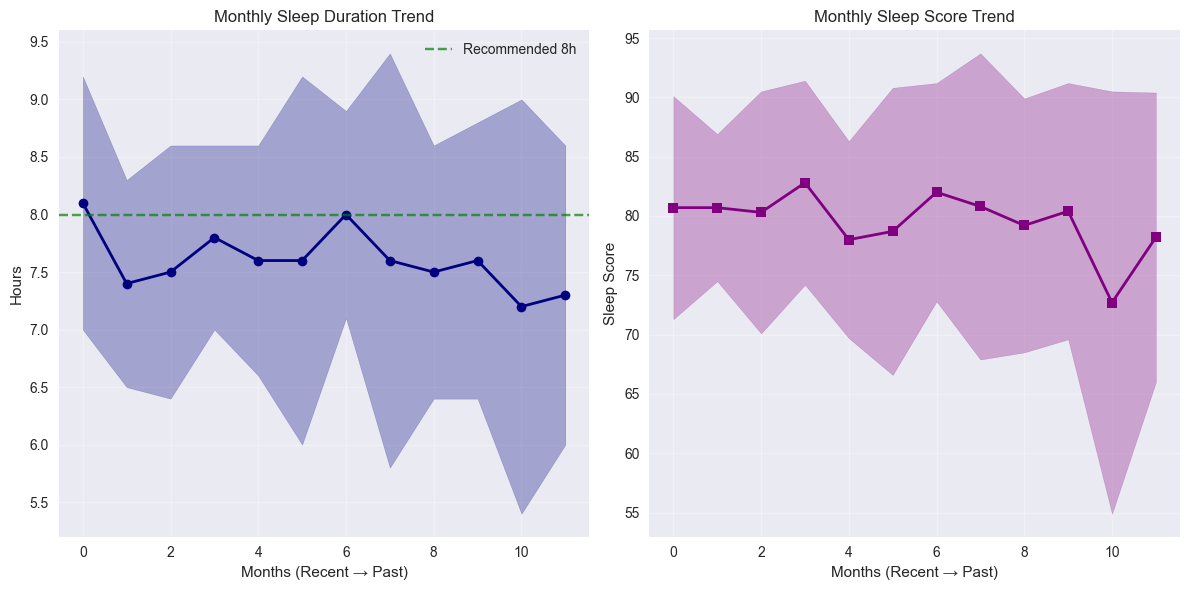

In [4]:
# Monthly Sleep Trends Analysis
print("📅 MONTHLY SLEEP TRENDS")
print("=" * 30)

# Group by month and calculate stats
df['month'] = df['day'].dt.to_period('M')
monthly_stats = df[df['total_sleep_hours'] > 0].groupby('month').agg({
    'total_sleep_hours': ['mean', 'std', 'count'],
    'score': ['mean', 'std'],
    'deep_sleep_hours': 'mean',
    'rem_sleep_hours': 'mean'
}).round(1)

monthly_stats.columns = ['Sleep_Avg', 'Sleep_Std', 'Nights', 'Score_Avg', 'Score_Std', 'Deep_Avg', 'REM_Avg']

print("📊 Monthly breakdown (last 6 months):")
for month in monthly_stats.tail(6).index:
    stats = monthly_stats.loc[month]
    print(f"   {month}: {stats['Sleep_Avg']:.1f}h avg (±{stats['Sleep_Std']:.1f}) | "
          f"Score {stats['Score_Avg']:.0f} | {stats['Nights']:.0f} nights")

# Plot monthly trends
plt.figure(figsize=(12, 6))
monthly_data = monthly_stats.tail(12)  # Last 12 months

plt.subplot(1, 2, 1)
plt.plot(range(len(monthly_data)), monthly_data['Sleep_Avg'], marker='o', linewidth=2, color='navy')
plt.fill_between(range(len(monthly_data)), 
                 monthly_data['Sleep_Avg'] - monthly_data['Sleep_Std'],
                 monthly_data['Sleep_Avg'] + monthly_data['Sleep_Std'], 
                 alpha=0.3, color='navy')
plt.axhline(y=8, color='green', linestyle='--', alpha=0.7, label='Recommended 8h')
plt.title('Monthly Sleep Duration Trend')
plt.xlabel('Months (Recent → Past)')
plt.ylabel('Hours')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(len(monthly_data)), monthly_data['Score_Avg'], marker='s', linewidth=2, color='purple')
plt.fill_between(range(len(monthly_data)), 
                 monthly_data['Score_Avg'] - monthly_data['Score_Std'],
                 monthly_data['Score_Avg'] + monthly_data['Score_Std'], 
                 alpha=0.3, color='purple')
plt.title('Monthly Sleep Score Trend')
plt.xlabel('Months (Recent → Past)')
plt.ylabel('Sleep Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


📅 WEEKLY SLEEP PATTERNS
🏢 WEEKDAYS (255 nights):
   Sleep: 7.5h avg (±1.1)
   Score: 80 avg (±10.6)
🏖️ WEEKENDS (103 nights):
   Sleep: 7.9h avg (±1.5)
   Score: 78 avg (±12.2)
📊 Weekend Difference: +0.4 hours

📊 Average by Day of Week:
   🏢 Monday: 7.8h (±1.1) | Score 81 | 51 nights
   🏢 Tuesday: 7.5h (±0.8) | Score 83 | 51 nights
   🏢 Wednesday: 7.4h (±1.3) | Score 80 | 51 nights
   🏢 Thursday: 7.3h (±1.1) | Score 79 | 51 nights
   🏢 Friday: 7.4h (±1.2) | Score 78 | 51 nights
   🏖️ Saturday: 7.5h (±1.5) | Score 76 | 52 nights
   🏖️ Sunday: 8.3h (±1.4) | Score 80 | 51 nights


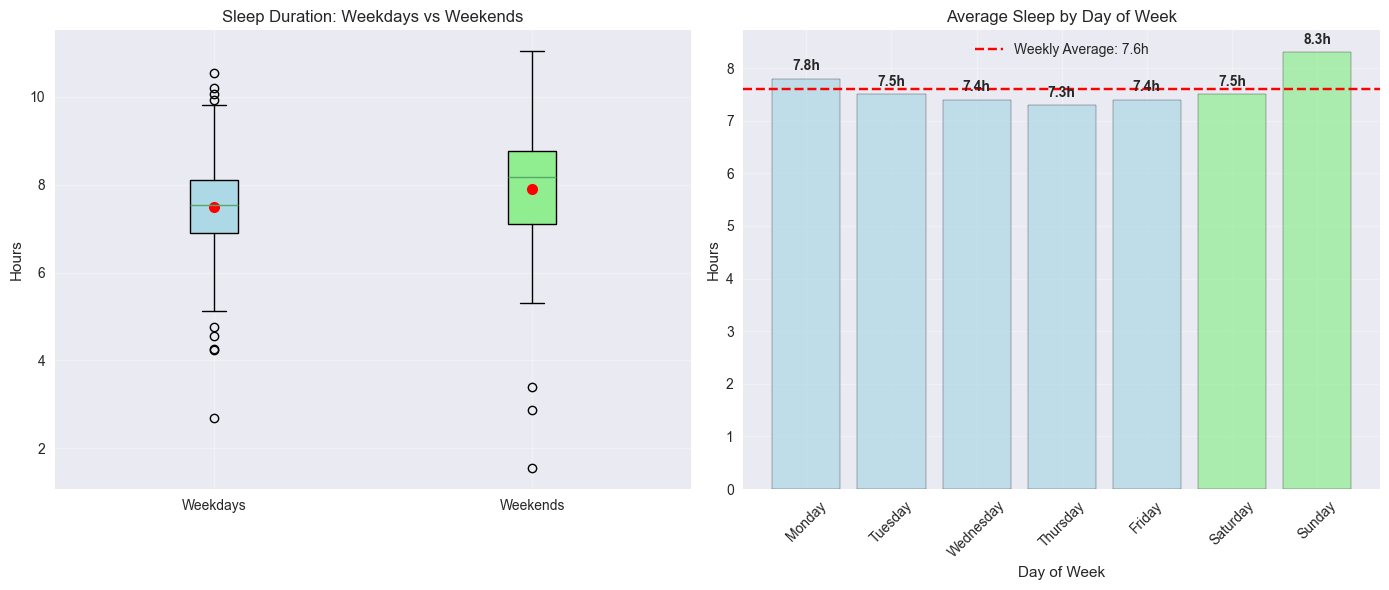

In [5]:
# Weekly Pattern Analysis - Weekday vs Weekend
print("📅 WEEKLY SLEEP PATTERNS")
print("=" * 30)

# Add day of week information
df['weekday'] = df['day'].dt.day_name()
df['is_weekend'] = df['day'].dt.weekday >= 5

# Weekday vs Weekend comparison
weekday_data = df[~df['is_weekend']]['total_sleep_hours'].dropna()
weekend_data = df[df['is_weekend']]['total_sleep_hours'].dropna()

weekday_clean = weekday_data[weekday_data > 0]
weekend_clean = weekend_data[weekend_data > 0]

weekday_scores = df[~df['is_weekend']]['score'].dropna()
weekend_scores = df[df['is_weekend']]['score'].dropna()

print(f"🏢 WEEKDAYS ({len(weekday_clean)} nights):")
print(f"   Sleep: {weekday_clean.mean():.1f}h avg (±{weekday_clean.std():.1f})")
print(f"   Score: {weekday_scores.mean():.0f} avg (±{weekday_scores.std():.1f})")

print(f"🏖️ WEEKENDS ({len(weekend_clean)} nights):")
print(f"   Sleep: {weekend_clean.mean():.1f}h avg (±{weekend_clean.std():.1f})")
print(f"   Score: {weekend_scores.mean():.0f} avg (±{weekend_scores.std():.1f})")

print(f"📊 Weekend Difference: {weekend_clean.mean() - weekday_clean.mean():+.1f} hours")

# Detailed breakdown by day of week
print("\n📊 Average by Day of Week:")
daily_stats = df[df['total_sleep_hours'] > 0].groupby('weekday').agg({
    'total_sleep_hours': ['mean', 'std', 'count'],
    'score': 'mean'
}).round(1)

# Reorder by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in day_order:
    if day in daily_stats.index:
        sleep_avg = daily_stats.loc[day, ('total_sleep_hours', 'mean')]
        sleep_std = daily_stats.loc[day, ('total_sleep_hours', 'std')]
        score_avg = daily_stats.loc[day, ('score', 'mean')]
        count = daily_stats.loc[day, ('total_sleep_hours', 'count')]
        emoji = '🏢' if day not in ['Saturday', 'Sunday'] else '🏖️'
        print(f"   {emoji} {day}: {sleep_avg:.1f}h (±{sleep_std:.1f}) | Score {score_avg:.0f} | {count:.0f} nights")

# Visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# Box plot for weekday vs weekend
weekday_weekend_data = [weekday_clean.values, weekend_clean.values]
labels = ['Weekdays', 'Weekends']
colors = ['lightblue', 'lightgreen']

box_plot = plt.boxplot(weekday_weekend_data, tick_labels=labels, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    
plt.title('Sleep Duration: Weekdays vs Weekends')
plt.ylabel('Hours')
plt.grid(True, alpha=0.3)

# Add mean lines
for i, data in enumerate(weekday_weekend_data):
    plt.plot(i+1, np.mean(data), 'ro', markersize=8)

plt.subplot(1, 2, 2)
# Bar chart by day of week
ordered_stats = daily_stats.reindex(day_order)
sleep_means = ordered_stats[('total_sleep_hours', 'mean')]
colors = ['lightblue' if day not in ['Saturday', 'Sunday'] else 'lightgreen' for day in day_order]

bars = plt.bar(range(len(day_order)), sleep_means, color=colors, alpha=0.7, edgecolor='black')
plt.axhline(y=sleep_means.mean(), color='red', linestyle='--', label=f'Weekly Average: {sleep_means.mean():.1f}h')
plt.title('Average Sleep by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hours')
plt.xticks(range(len(day_order)), day_order, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, sleep_means)):
    if not np.isnan(value):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{value:.1f}h', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


💯 SLEEP QUALITY ANALYSIS
🏆 Sleep Quality Distribution:
   💚 Excellent (90+): 45 nights (12.6%)
   💛 Good (70-89): 264 nights (73.7%)
   🧡 Fair (50-69): 37 nights (10.3%)
   ❤️ Poor (<50): 12 nights (3.4%)

🩺 Health Metrics:
   📈 Sleep Score: 80 avg (range: 27-97)
   🫁 SpO2: 95.4% avg (±1.3%)
   😌 Stress: 19.7 avg (±7.3)

⚡ Sleep Efficiency: 98.1% avg (±2.8%)


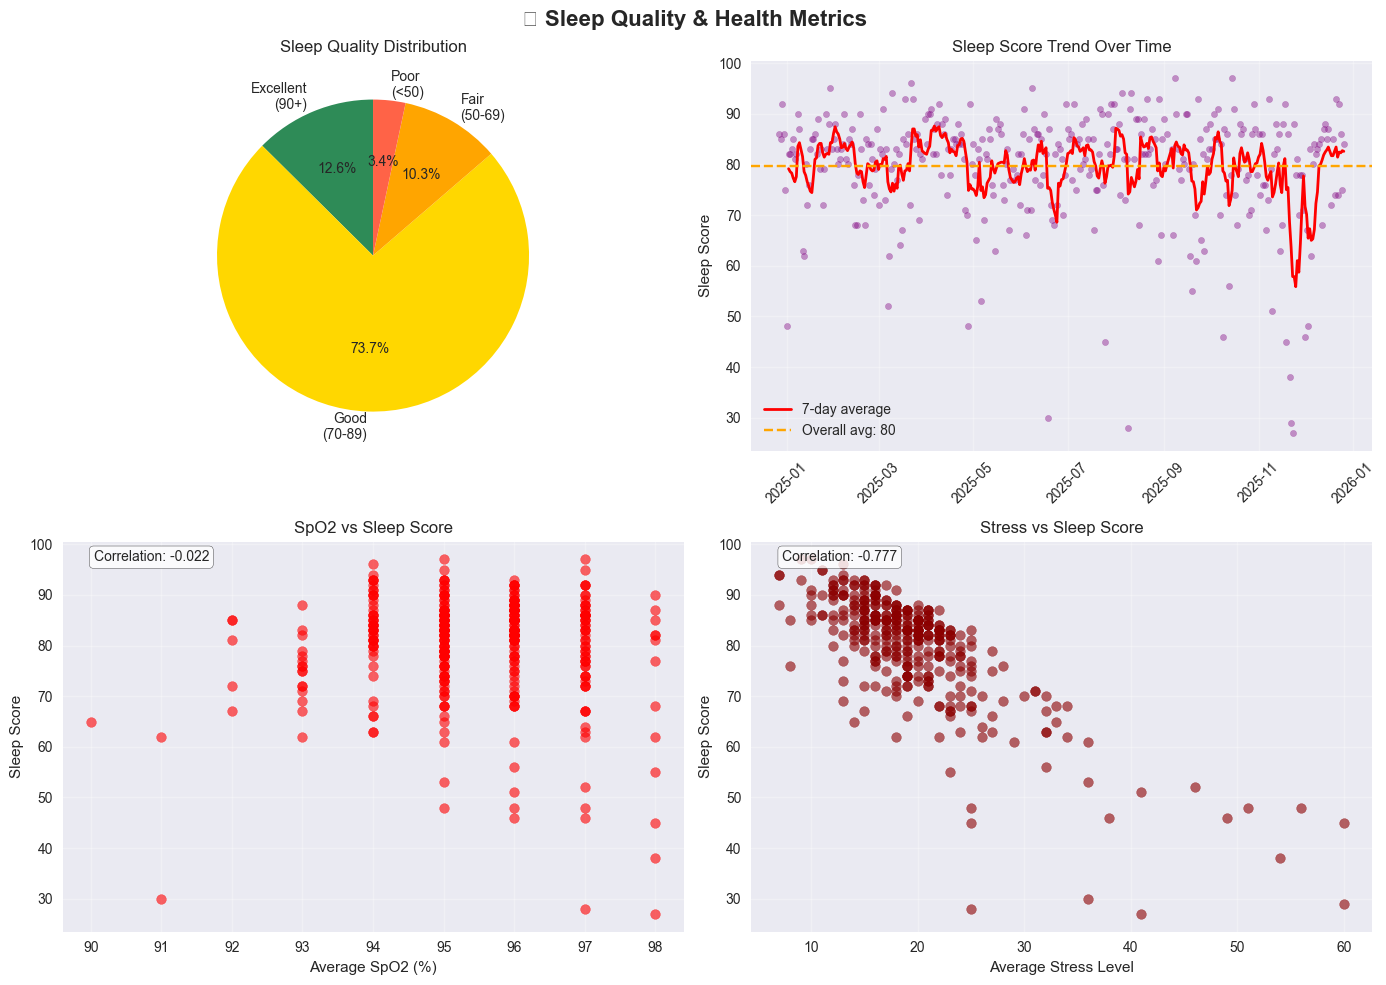

In [6]:
# Sleep Quality & Health Metrics Analysis
print("💯 SLEEP QUALITY ANALYSIS")
print("=" * 35)

score_data = df['score'].dropna()
spo2_data = df['avg_spo2'].dropna()
stress_data = df['avg_stress'].dropna()

# Sleep quality distribution
if len(score_data) > 0:
    excellent = (score_data >= 90).sum()
    good = ((score_data >= 70) & (score_data < 90)).sum()
    fair = ((score_data >= 50) & (score_data < 70)).sum()
    poor = (score_data < 50).sum()
    
    print(f"🏆 Sleep Quality Distribution:")
    print(f"   💚 Excellent (90+): {excellent} nights ({excellent/len(score_data)*100:.1f}%)")
    print(f"   💛 Good (70-89): {good} nights ({good/len(score_data)*100:.1f}%)")
    print(f"   🧡 Fair (50-69): {fair} nights ({fair/len(score_data)*100:.1f}%)")
    print(f"   ❤️ Poor (<50): {poor} nights ({poor/len(score_data)*100:.1f}%)")

print(f"\n🩺 Health Metrics:")
print(f"   📈 Sleep Score: {score_data.mean():.0f} avg (range: {score_data.min():.0f}-{score_data.max():.0f})")
print(f"   🫁 SpO2: {spo2_data.mean():.1f}% avg (±{spo2_data.std():.1f}%)")
print(f"   😌 Stress: {stress_data.mean():.1f} avg (±{stress_data.std():.1f})")

# Sleep efficiency analysis
df['sleep_efficiency'] = ((df['total_sleep_hours'] - df['awake_hours']) / df['total_sleep_hours'] * 100).clip(0, 100)
efficiency_data = df['sleep_efficiency'].dropna()
efficiency_clean = efficiency_data[(efficiency_data > 50) & (efficiency_data <= 100)]

print(f"\n⚡ Sleep Efficiency: {efficiency_clean.mean():.1f}% avg (±{efficiency_clean.std():.1f}%)")

# Create quality metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('🌙 Sleep Quality & Health Metrics', fontsize=16, fontweight='bold')

# 1. Quality distribution pie chart
quality_counts = [excellent, good, fair, poor]
quality_labels = ['Excellent\n(90+)', 'Good\n(70-89)', 'Fair\n(50-69)', 'Poor\n(<50)']
quality_colors = ['#2E8B57', '#FFD700', '#FFA500', '#FF6347']

axes[0,0].pie([x for x in quality_counts if x > 0], 
              labels=[label for i, label in enumerate(quality_labels) if quality_counts[i] > 0],
              colors=[color for i, color in enumerate(quality_colors) if quality_counts[i] > 0],
              autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Sleep Quality Distribution')

# 2. Sleep score over time with 30-day moving average
score_over_time = df[['day', 'score']].dropna().sort_values('day')
axes[0,1].scatter(score_over_time['day'], score_over_time['score'], alpha=0.4, s=20, color='purple')
# Add 7-day moving average
score_over_time['score_ma7'] = score_over_time['score'].rolling(7).mean()
axes[0,1].plot(score_over_time['day'], score_over_time['score_ma7'], 
               color='red', linewidth=2, label='7-day average')
axes[0,1].axhline(y=score_data.mean(), color='orange', linestyle='--', 
                  label=f'Overall avg: {score_data.mean():.0f}')
axes[0,1].set_title('Sleep Score Trend Over Time')
axes[0,1].set_ylabel('Sleep Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. SpO2 vs Sleep Score correlation
spo2_score = df[['avg_spo2', 'score']].dropna()
axes[1,0].scatter(spo2_score['avg_spo2'], spo2_score['score'], alpha=0.6, color='red')
axes[1,0].set_title('SpO2 vs Sleep Score')
axes[1,0].set_xlabel('Average SpO2 (%)')
axes[1,0].set_ylabel('Sleep Score')
if len(spo2_score) > 1:
    corr = spo2_score.corr().loc['avg_spo2', 'score']
    axes[1,0].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                   transform=axes[1,0].transAxes, fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
axes[1,0].grid(True, alpha=0.3)

# 4. Stress vs Sleep Score correlation  
stress_score = df[['avg_stress', 'score']].dropna()
axes[1,1].scatter(stress_score['avg_stress'], stress_score['score'], alpha=0.6, color='darkred')
axes[1,1].set_title('Stress vs Sleep Score')
axes[1,1].set_xlabel('Average Stress Level')
axes[1,1].set_ylabel('Sleep Score')
if len(stress_score) > 1:
    corr = stress_score.corr().loc['avg_stress', 'score']
    axes[1,1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                   transform=axes[1,1].transAxes, fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
# Custom Analysis Functions - Modify these for your specific needs!

def analyze_sleep_period(start_date, end_date, label="Custom Period"):
    """
    Analyze sleep for any custom date range
    
    Args:
        start_date: '2024-01-01' format
        end_date: '2024-12-31' format  
        label: Description for the period
    """
    
    period_data = df[
        (df['day'] >= start_date) & 
        (df['day'] <= end_date) &
        (df['total_sleep_hours'] > 0)
    ]
    
    if len(period_data) == 0:
        print(f"⚠️ No sleep data found for {label}")
        return
    
    sleep_hours = period_data['total_sleep_hours']
    scores = period_data['score'].dropna()
    
    print(f"\n🔍 {label.upper()} ANALYSIS")
    print(f"📅 Period: {start_date} to {end_date}")
    print(f"📊 Nights analyzed: {len(period_data)}")
    print(f"⏰ Sleep duration: {sleep_hours.mean():.1f}h avg (±{sleep_hours.std():.1f}h)")
    print(f"📏 Range: {sleep_hours.min():.1f} - {sleep_hours.max():.1f} hours")
    print(f"💯 Sleep score: {scores.mean():.0f} avg (±{scores.std():.1f})")
    print(f"🎯 Best night: {sleep_hours.max():.1f}h (Score: {scores.max():.0f})")
    print(f"😴 Sleep efficiency: {period_data['sleep_efficiency'].mean():.1f}%")
    
    return period_data

# Example analyses - modify these dates for your interests!
print("🔬 CUSTOM PERIOD ANALYSES")
print("=" * 35)

# Analyze different seasons
analyze_sleep_period('2024-12-01', '2025-02-28', 'Winter 2024-25')
analyze_sleep_period('2024-06-01', '2024-08-31', 'Summer 2024')
analyze_sleep_period('2024-09-01', '2024-11-30', 'Fall 2024')

# Recent vs past comparison
analyze_sleep_period('2024-09-01', '2025-09-08', 'Last 12 months')
analyze_sleep_period('2025-01-01', '2025-09-08', 'Year 2025 so far')

# You can add your own custom date ranges here:
# analyze_sleep_period('2024-01-01', '2024-03-31', 'Q1 2024')
# analyze_sleep_period('2024-07-01', '2024-07-31', 'July 2024')

print("\n✨ Analysis complete! Try modifying the dates above for different periods.")


🔬 CUSTOM PERIOD ANALYSES

🔍 WINTER 2024-25 ANALYSIS
📅 Period: 2024-12-01 to 2025-02-28
📊 Nights analyzed: 63
⏰ Sleep duration: 7.8h avg (±1.1h)
📏 Range: 5.8 - 10.1 hours
💯 Sleep score: 81 avg (±7.9)
🎯 Best night: 10.1h (Score: 95)
😴 Sleep efficiency: 98.5%
⚠️ No sleep data found for Summer 2024
⚠️ No sleep data found for Fall 2024

🔍 LAST 12 MONTHS ANALYSIS
📅 Period: 2024-09-01 to 2025-09-08
📊 Nights analyzed: 250
⏰ Sleep duration: 7.7h avg (±1.2h)
📏 Range: 1.6 - 11.0 hours
💯 Sleep score: 81 avg (±9.8)
🎯 Best night: 11.0h (Score: 97)
😴 Sleep efficiency: 98.1%

🔍 YEAR 2025 SO FAR ANALYSIS
📅 Period: 2025-01-01 to 2025-09-08
📊 Nights analyzed: 245
⏰ Sleep duration: 7.7h avg (±1.2h)
📏 Range: 1.6 - 11.0 hours
💯 Sleep score: 81 avg (±9.8)
🎯 Best night: 11.0h (Score: 97)
😴 Sleep efficiency: 98.2%

✨ Analysis complete! Try modifying the dates above for different periods.


In [8]:
# Data Summary & Tips for Further Analysis

print("📋 COMPLETE DATA SUMMARY")
print("=" * 30)

# Overall data overview
total_nights = len(df[df['total_sleep_hours'] > 0])
date_range = f"{df['day'].min().date()} to {df['day'].max().date()}"

print(f"📅 Date Range: {date_range}")
print(f"📊 Total Nights: {total_nights}")
print(f"🗓️ Days Covered: {(df['day'].max() - df['day'].min()).days + 1}")
print(f"📈 Data Completeness: {total_nights / ((df['day'].max() - df['day'].min()).days + 1) * 100:.1f}%")

print(f"\n🌙 SLEEP INSIGHTS SUMMARY:")
valid_sleep = df[df['total_sleep_hours'] > 0]['total_sleep_hours']
print(f"   📊 Average Sleep: {valid_sleep.mean():.1f} hours")
print(f"   📊 Sleep Quality: {df['score'].mean():.0f}/100 average score")
print(f"   📊 Consistency: {valid_sleep.std():.1f}h standard deviation")
print(f"   📊 Health Metrics: SpO2 {df['avg_spo2'].mean():.1f}%, Stress {df['avg_stress'].mean():.1f}")

print(f"\n💡 QUICK INSIGHTS:")
recent_sleep = valid_sleep.head(30).mean() if len(valid_sleep) >= 30 else valid_sleep.mean()
overall_sleep = valid_sleep.mean()
trend = recent_sleep - overall_sleep

print(f"   📈 Recent Trend: {trend:+.1f}h vs overall average ({'improving' if trend > 0 else 'declining'})")
print(f"   🏆 Best Sleep Score: {df['score'].max():.0f}/100")
print(f"   ⚡ Sleep Efficiency: {efficiency_clean.mean():.1f}% average")
print(f"   🏖️ Weekend Bonus: {weekend_clean.mean() - weekday_clean.mean():+.1f}h vs weekdays")

print(f"\n🔍 FURTHER ANALYSIS IDEAS:")
print("   • Compare sleep before/after travel or events")
print("   • Analyze sleep vs activity data correlations") 
print("   • Study seasonal patterns across multiple years")
print("   • Investigate sleep score vs recovery metrics")
print("   • Create custom alerts for poor sleep patterns")

print(f"\n📊 AVAILABLE SLEEP METRICS:")
print("   • total_sleep, deep_sleep, light_sleep, rem_sleep, awake")
print("   • score, avg_spo2, avg_stress, qualifier")
print("   • Custom calculated: sleep_efficiency, weekday patterns")

# Close database connection
conn.close()
print(f"\n✅ Analysis complete! Database connection closed.")
print(f"🚀 Ready to explore your {total_nights} nights of sleep data!")


📋 COMPLETE DATA SUMMARY
📅 Date Range: 2024-12-27 to 2025-12-26
📊 Total Nights: 358
🗓️ Days Covered: 365
📈 Data Completeness: 98.1%

🌙 SLEEP INSIGHTS SUMMARY:
   📊 Average Sleep: 7.6 hours
   📊 Sleep Quality: 80/100 average score
   📊 Consistency: 1.2h standard deviation
   📊 Health Metrics: SpO2 95.4%, Stress 19.7

💡 QUICK INSIGHTS:
   📈 Recent Trend: -0.3h vs overall average (declining)
   🏆 Best Sleep Score: 97/100
   ⚡ Sleep Efficiency: 98.1% average
   🏖️ Weekend Bonus: +0.4h vs weekdays

🔍 FURTHER ANALYSIS IDEAS:
   • Compare sleep before/after travel or events
   • Analyze sleep vs activity data correlations
   • Study seasonal patterns across multiple years
   • Investigate sleep score vs recovery metrics
   • Create custom alerts for poor sleep patterns

📊 AVAILABLE SLEEP METRICS:
   • total_sleep, deep_sleep, light_sleep, rem_sleep, awake
   • score, avg_spo2, avg_stress, qualifier
   • Custom calculated: sleep_efficiency, weekday patterns

✅ Analysis complete! Database connec

In [9]:
# Bonus: Direct SQL Queries for Advanced Users
# Uncomment and run any of these for specific insights

print("🛠️ ADVANCED SQL QUERIES")
print("Uncomment any query below and run for specific analysis:")
print()

# Reconnect for additional queries (uncomment to use)
# conn = sqlite3.connect(os.path.expanduser('~/HealthData/DBs/garmin.db'))

# # Find your best and worst sleep weeks
# best_weeks = """
# SELECT 
#     strftime('%Y-W%W', day) as week,
#     COUNT(*) as nights,
#     AVG(CAST(substr(total_sleep, 1, 2) AS REAL) + CAST(substr(total_sleep, 4, 2) AS REAL)/60.0) as avg_hours,
#     AVG(score) as avg_score
# FROM sleep 
# WHERE day >= date('now', '-365 days') 
#   AND total_sleep != '00:00:00'
# GROUP BY strftime('%Y-W%W', day)
# HAVING COUNT(*) >= 3  -- At least 3 nights of data
# ORDER BY avg_score DESC
# LIMIT 5;
# """

# # Sleep patterns around specific events (modify dates as needed)
# event_analysis = """
# SELECT 
#     day,
#     total_sleep as duration,
#     score,
#     avg_stress,
#     CASE 
#         WHEN day BETWEEN '2024-12-20' AND '2025-01-05' THEN 'Holiday Period'
#         WHEN strftime('%w', day) IN ('0', '6') THEN 'Weekend'
#         ELSE 'Regular Weekday'
#     END as period_type
# FROM sleep 
# WHERE day >= date('now', '-90 days')
#   AND total_sleep != '00:00:00'
# ORDER BY day DESC;
# """

# # Monthly sleep quality trends
# monthly_trends = """
# SELECT 
#     strftime('%Y-%m', day) as month,
#     COUNT(*) as nights,
#     printf('%.1f', AVG(CAST(substr(total_sleep, 1, 2) AS REAL) + CAST(substr(total_sleep, 4, 2) AS REAL)/60.0)) as avg_sleep,
#     printf('%.0f', AVG(score)) as avg_score,
#     printf('%.1f', AVG(avg_spo2)) as avg_spo2,
#     printf('%.1f', AVG(avg_stress)) as avg_stress
# FROM sleep 
# WHERE day >= date('now', '-12 months') 
#   AND total_sleep != '00:00:00'
# GROUP BY strftime('%Y-%m', day)
# ORDER BY month DESC;
# """

# # Example: Run a query (uncomment to use)
# result = pd.read_sql_query(monthly_trends, conn)
# print(result)

# # Always close connection when done
# # conn.close()

print("💡 TIPS:")
print("• Modify the date ranges in any query for your specific analysis")
print("• Use 'date('now', '-X days/months/years')' for relative dates")
print("• Combine with activity data by joining tables")
print("• Export results to CSV: df.to_csv('my_sleep_analysis.csv')")
print("\n🌙 Happy analyzing your sleep patterns!")


🛠️ ADVANCED SQL QUERIES
Uncomment any query below and run for specific analysis:

💡 TIPS:
• Modify the date ranges in any query for your specific analysis
• Use 'date('now', '-X days/months/years')' for relative dates
• Combine with activity data by joining tables
• Export results to CSV: df.to_csv('my_sleep_analysis.csv')

🌙 Happy analyzing your sleep patterns!
